## American Options

In this document, we continue the application of the theory discussed in the research paper and are now looking to price American options in the risk-neutral measure $\mathbb{Q}$, which are dependent upon the same underlying asset $S_t$ following a geometric Brownian motion (GBM). Due to the extra condition, in relation to the European vanilla option, of any holder of the contingent claim also having the right to exercise at any time before and including maturity, we lack a simple, closed-form solution - unlike the European counterpart. We discretise time and space appropriately and discretise the parabolic PDE defined in the variational inequality using the Crank-Nicholson finite difference method to transform our problem into a linear complementarity problem (LCP), which is then solved via projected successive over-relaxation with relaxation factor $\omega \in (1, 2)$. Subsequently, we yield solution which is guaranteed to converge, unconditionally stable, and accurate up to second-order time. 

For model validation and further insights into the mechanics of our solver, we plot the American and European call and put prices against the payoff, to ensure no-arbitrage conditions are satisfied. Furthermore, we also plot the free boundary curve produced from the American problem, to understand where the partition in our space-time grid lies that splits the continuation and exercise region.

In [1]:
# Import necessary libaries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Allow plots to be exported
from pathlib import Path

print("Working directory:", Path.cwd())

FIG_DIR = Path("project/figures/appendixC")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(fig, name, fmt="pdf"):
    path = FIG_DIR / f"{name}.{fmt}"
    fig.savefig(path, bbox_inches="tight")
    print("Saved:", path)

Working directory: /Users/milanleal/Documents/Vanilla_Pricing


In [3]:
# Set parameter values
St = 100.0
K = 100.0
T = 1.0
r = 0.05
q = 0.02
sigma = 0.20

S_max = 500
N = 504
M = 1000

theta = 0.5
omega = 1.5
tol = 1e-8
max_iter = 10000

### Time-space grid

We discretise both the time and space intervals uniformly, so that the continuous intervals $[0,T]$ and $[0, S_\text{max}]$ become, respectively

$$0 = t_0 < t_1 < \dots < t_N = T, \quad \Delta t = \frac{T}{N}$$
$$0 = s_0 < s_1 < \dots < s_M = s_\text{max}, \quad \Delta s = \frac{s_\text{max}}{M}$$

In [4]:
# Define time and spatial discretisation
def discrete_time_space(T, S_max, N, M):

    """
    Parameters:
    T: Option contract length (years)
    S_max: Maximum underlying asset price
    N: Number of time steps
    M: Number of spatial steps

    Returns:
    Ts: NumPy array of time points 
    Ss: NumPy array of spatial points
    """
    
    epsilon = 1e-12
    
    if T <= epsilon:
        raise ValueError("T must be strictly positive")

    if S_max <= epsilon:
        raise ValueError("S_max must be strictly positive")
    
    if type(N) != int or N <= 0:
        raise ValueError("N must be a strictly positive integer")

    if type(M) != int or M <= 0:
        raise ValueError("M must be a strictly positive integer")

    T_grid = np.linspace(0.0, T, N+1)
    S_grid = np.linspace(0.0, S_max, M+1)

    delta_t = T / N
    delta_s = S_max / M

    return T_grid, S_grid, delta_t, delta_s

### Payoff

For any time $t_n$ on the discretised grid, we define the payoff vector $\boldsymbol{\Psi} := (\Psi(s_0), \dots, \Psi(s_M))^T$, where $\Psi$ denotes the same payoff function we used for the European options.

In [5]:
# Define vectorised payoff function
def psi_payoff(S_grid, K, option_type):
    
    """
    Computes a vectorised payoff of American call and put options at any fixed time node across all spatial nodes

    Parameters: 
    S_grid: NumPy array of spatial nodes
    K: Strike price
    option_type: Option type

    Returns:
    payoff: Payoff of the American option
    """
    
    epsilon = 1e-12

    if option_type not in ("call", "put"):
        raise ValueError("option_type must be either 'call' or 'put'")
        
    if K <= epsilon:
        raise ValueError("K must be strictly positive")

    if option_type == "call":
        payoff = np.maximum(S_grid - K, 0.0)
        
    else:
        payoff = np.maximum(K - S_grid, 0.0)

    return payoff

### Dirichlet Bounds

At the nodes on the time-space grid which are at the boundary, we use Dirichlet boundaries to price the American options. Let $C(t_n, s_m)$ and $P(t_n, s_m)$ denote the respective prices of an American call and put option on the discretised time-space grid and let $\tau$ be the time in years until maturity of the contract. At $s_0 = 0$, we have

$$C(t_n, 0) = 0, \quad P(t_n, 0) = K$$

At $s = s_\text{max}$, the American put price is always

$$P(t_n, s_\text{max}) = 0$$

For an American call, the price is $q$-dependent at $s = s_\text{max}$

$$ C(t_n, s_\text{max}) = \begin{cases} s_\text{max} - Ke^{-r\tau}, & q = 0 \\ s_\text{max} - K, & q>0 \end{cases} $$

In [6]:
# Define the Dirichlet bounds for American call and put options
def dirichlet_bounds(S_max, tau, K, r, q, option_type):

    """
    Defines the Dirichlet bounds for American call and put option prices when S = 0 and S = S_max

    Parameters:
    S_max: Maximum underlying asset price in spatial discretisation
    tau: Time until maturity (years)
    K: Strike price
    r: Risk-free interest rate
    q: Continuous dividend yield
    option_type: Option type

    Returns:
    dirichlet_lower: American option price lower bound (S = 0)
    dirichlet_upper: American option price upper bound (S = S_max)
    """

    epsilon = 1e-12

    if option_type not in ("call", "put"):
        raise ValueError("option_type must be either 'call' or 'put'")

    if K <= 0.0:
        raise ValueError("K must be strictly positive")

    if r < -epsilon or q < -epsilon:
        raise ValueError("r, q must be non-negative")
        
    if option_type == "call":
        dirichlet_lower = 0.0
        
        if abs(q) < epsilon:
            dirichlet_upper = S_max - K * np.exp(-r * tau)
        else:
            dirichlet_upper = S_max - K
            
    else:
        dirichlet_lower = K
        dirichlet_upper = 0.0
    
    return dirichlet_lower, dirichlet_upper

### Building $A_n$ and $\boldsymbol{b}_n$

Let $v_{n,m}$ denote the price of the American option at node $(t_n, s_m)$. Then, the Black-Scholes spatial generator on any interior node $s_m$, $m\in\{1, \dots, M-1\}$, can be approximated with
$$(\mathcal{L}_hv)_m = (\alpha_m - \beta_m)v_{n, m-1} - 2\alpha_mv_{n, m} + (\alpha_m + \beta_m)v_{n, m+1}$$

where
$$\alpha_m := \frac{\sigma^2 s_m^2}{2(\Delta s_m)^2}, \quad \beta_m := \frac{(r-q)s_m}{2\Delta s_m}$$

Then the spatial $M$-matrix is characterised by $A_h := \mathcal{L_h} - rI$

From the discretisation and convex approximation of the PDE $\partial_t V(t,s) + \mathcal{A}V(t,s) \le 0$, which is discussed in the paper, we find that
$$A_n\boldsymbol{V}_n = \boldsymbol{b}_n, \quad A_n := I - \vartheta\Delta tA_h, \quad \boldsymbol{b}_n := (I + (1-\vartheta)\Delta t A_h)\boldsymbol{V}^{n+1}$$

In [7]:
# Build the spatial matrix A_h := L_h - rI
def build_Ah(S_grid, delta_s, sigma, r, q):

    """
    Builds the spatial matrix A_h using the discretisation of the Black-Scholes spatial generator L_h

    Paramters:
    S_grid: NumPy array of spatial nodes
    delta_s: Uniform spatial step size
    sigma: Annualised volatility
    r: Risk-free interest rate
    q: Continuous dividend yield

    Returns:
    A_h: NumPy array for spatial matrix A_h
    """

    epsilon = 1e-12
    M = len(S_grid) - 1
    
    if sigma < 0.0 or r < 0.0 or q < 0.0:
        raise ValueError("sigma, r, q must be non-negative")    
        
    alpha = (sigma**2 * S_grid[1:M]**2) / (2.0 * delta_s**2)
    beta = ((r - q) * S_grid[1:M]) / (2.0 * delta_s)

    lower = alpha - beta
    diagonal = -2.0 * alpha
    upper = alpha + beta

    L_h = np.zeros((M+1, M+1))

    for i in range(1, M):
        
        L_h[i, i-1] = lower[i-1]
        L_h[i, i] = diagonal[i-1]
        L_h[i, i+1] = upper[i-1]

    A_h = L_h - r * np.identity(M+1)
        
    return A_h

In [8]:
# Build the M-matrix A_n and vector b_n
def build_An_bn(A_h, theta, delta_t, V_next):

    """
    Builds the M-matrix A_n and the vector b_n

    Parameters:
    A_h: Spatial matrix A_h
    theta: Time-stepping parameter in the theta-scheme
    delta_t: Uniform time step size
    V_next: NumPy array of American option price at time t_{n+1}

    Returns:
    A_n: NumPy array for M-matrix A_n
    b_n: NumPy array for vector b_n
    """

    M = A_h.shape[0] - 1
    I = np.identity(M+1)

    A_n = I - theta * delta_t * A_h
    b_n = (I + (1.0 - theta) * delta_t * A_h) @ V_next

    return A_n, b_n

### Projected Successive Over-Relaxation

Let $\tilde{\boldsymbol{V}}^{(k)}$ denote the $k^{th}$ iteration of the American option price at any time $t_n$ under SOR. For simplicity of notation, let $A \equiv A_n$ and $\boldsymbol{b} \equiv \boldsymbol{b}_n$. By decomposing $A$ into the sum of a strictly lower-triangular matrix $L$, a diagonal matrix $D$, and a strictly upper-triangular matrix $U$, we can compute each element of $\tilde{\boldsymbol{V}}^{(k)}$ sequentially

$$\tilde{V}_i^{(k+1)} = (1-\omega){V}_i^{(k)} + \frac{\omega}{A_{ii}}\left(\boldsymbol{b}_i - \sum_{j<i}A_{ij}\tilde{V}_{j}^{(k+1)} - \sum_{j>i}A_{ij}V_j^{(k)}\right), \quad i = 1, \dots, n$$

The projection $P$ enforces no arbitrage at any node in the time-space grid
$$\boldsymbol{V}_i^{(k+1)} = P(\tilde{\boldsymbol{V}}_i^{(k+1)}) = \max\{\boldsymbol{\Psi}_i, \tilde{\boldsymbol{V}}_i^{(k+1)}\}, \quad i = 0, \dots, M$$

In [9]:
# Define PSOR algorithm
def psor_solver(A_n, b_n, payoff, V_init, dir_lower, dir_upper, omega, tol, max_iter):

    """
    Solves LCP using projected successive over-relaxation

    Parameters:
    A_n: M-matrix A_n
    b_n: Vector b_n
    payoff: Payoff function vector
    V_init: Intitial guess of V_n
    dir_lower: Dirichlet lower bound (S = 0)
    dir_upper: Dirichlet upper bound (S = S_max)
    omega: Relaxation factor
    tol: Stopping tolerance on l-infinity norm
    max_iter: Maximum number of PSOR iterations

    Returns:
    V: Solution vector at time node t_n
    """

    if omega <=1 or omega >= 2:
        raise ValueError("omega must be strictly greater than 1 and strictly less than 2")

    if type(max_iter) != int or max_iter <= 0:
        raise ValueError("max_iter must be a strictly positive integer")

    M = A_n.shape[0]
    V = V_init.copy()
    
    V[0] = dir_lower
    V[-1] = dir_upper

    for k in range(max_iter):
        V_old = V.copy()

        for i in range (1, M):
            s1 = A_n[i, :i] @ V[:i]
            s2 = A_n[i, i+1:] @ V_old[i+1:]
            v_tilde = (1.0 - omega) * V[i] + (omega / A_n[i, i]) * (b_n[i] - s1 - s2)

            V[i] = np.maximum(payoff[i], v_tilde)

        V[0] = dir_lower
        V[-1] = dir_upper

        if np.linalg.norm(V - V_old, ord = np.inf) < tol:
            break
            
    return V

In [10]:
def american_fd_price(St, T, K, r, q, sigma, S_max, N, M, theta, omega, tol, max_iter, option_type):

    """
    Prices American call and put options from the Crank-Nicolson finite difference method with Rannacher start up and solved via PSOR

    Parameters:
    St: Underlying asset price at time t
    T: Time to maturity
    K: Strike price
    r: Risk-free interest rate
    q: Continuous dividen yield
    sigma: Annuslised volatility
    S_max: Maximum underlying asset price in spatial discretisation
    N: Number of time steps
    M: Number of spatial steps
    theta: Time-stepping parameter in the theta-scheme
    omega: Relaxation factor
    tol: Stopping tolerance on l-infinity norm
    max_iter: Maximum number of PSOR iterations
    option_type: Option type

    Returns:
    price_t0: NumPy array of American option prices at time t_0
    V: NumPy array of all American option prices in the (N+1) x (M+1) grid
    T_grid: Time grid
    S_grid: Spatial grid
    """

    T_grid, S_grid, delta_t, delta_s = discrete_time_space(T, S_max, N, M)
    A_h = build_Ah(S_grid, delta_s, sigma, r, q)
    payoff = psi_payoff(S_grid, K, option_type)

    V = np.zeros((N+1, M+1))
    V[N, :] = payoff
    V_next = payoff.copy()

    for n in range(N-1, -1, -1):

        tau_n = T - T_grid[n]
        tau_next = T - T_grid[n+1]

        dir_lower_next, dir_upper_next = dirichlet_bounds(S_max, tau_next, K, r, q, option_type)
        V_next[0] = dir_lower_next
        V_next[-1] = dir_upper_next

        A_n, b_n = build_An_bn(A_h, theta, delta_t, V_next)
        dir_lower, dir_upper = dirichlet_bounds(S_max, tau_n, K, r, q, option_type)

        V_init = V_next.copy()
        V_init[0] = dir_lower
        V_init[-1] = dir_upper

        V_n = psor_solver(A_n, b_n, payoff, V_init, dir_lower, dir_upper, omega, tol, max_iter)
        V[n, :] = V_n
        V_next = V_n

        price_t0 = np.interp(St, S_grid, V[0, :])
    
    return price_t0, V, T_grid, S_grid

In [11]:
call_price_t0, C, T_grid, S_grid = american_fd_price(St, T, K, r, q, sigma, S_max, N, M, theta, omega, tol, max_iter, option_type = "call")
put_price_t0, P, _, _ = american_fd_price(St, T, K, r, q, sigma, S_max, N, M, theta, omega, tol, max_iter, option_type = "put")

print(f"Time grid: interval = [0, {T}], time step = {T / N}")
print(f"Spatial grid: interval = [0, {S_max}, spatial step = {S_max / M}]")
print(f"American call price at t=0, S = {St}: {call_price_t0:.6f}")
print(f"American put price at t=0, S = {St}: {put_price_t0:.6f}")

Time grid: interval = [0, 1.0], time step = 0.001984126984126984
Spatial grid: interval = [0, 500, spatial step = 0.5]
American call price at t=0, S = 100.0: 9.226407
American put price at t=0, S = 100.0: 6.659937


In [12]:
# Copy-and-pasted European call and put option price under Black-Scholes formula from european_options.ipynb notebook
def european_bs_price(St, tau, K, r, q, sigma, option_type):

    """
    Computes the price of a European call or put option using the Black-Scholes formula

    Parameters:
    St: Underlying asset price at time t
    tau: Time until maturity (years)
    K: Strike price
    r: Risk-free interest rate
    q: Dividend yield
    sigma: Annualised volatility
    option_type: Option type

    Returns:
    price: European call or put option price
    """

    epsilon = 1e-12

    if option_type not in ("call", "put"):
        raise ValueError("option_type must be 'call' or 'put'.")

    if K <= 0.0:
        raise ValueError("K must be strictly positive")

    if St < 0.0 or tau < 0.0 or sigma < 0.0:
        raise ValueError("St, tau, sigma must be non-negative.")

    Ft = St * np.exp((r - q) * tau)
    discount = np.exp(-r * tau)
    
    if St <= epsilon:
        if option_type == "call":
            price = 0.0
        else:
            price = K * discount

    elif tau <= epsilon:
        if option_type == "call":
            price = np.maximum(St - K, 0.0) 
        else:
            price = np.maximum(K - St, 0.0)

    elif sigma <= epsilon:
        if option_type == "call":
            price = discount * np.maximum(Ft - K, 0.0)
        else:
            price = discount * np.maximum(K - Ft, 0.0)

    else:
        d1 = (np.log(Ft / K) + 0.5 * sigma**2 * tau) / (sigma * np.sqrt(tau))
        d2 = d1 - sigma * np.sqrt(tau)
        if option_type == "call":
            price = discount * (Ft * norm.cdf(d1) - K * norm.cdf(d2))
        else:
            price = discount * (K * norm.cdf(-d2) - Ft * norm.cdf(-d1))

    return price

# Print Black-Scholes European call and put option prices
print(f"Black-Scholes European call price: {european_bs_price(St, T, K, r, q, sigma, option_type = 'call'):.6f}")
print(f"Black-Scholes European put price: {european_bs_price(St, T, K, r, q, sigma, option_type = 'put'):.6f}")

Black-Scholes European call price: 9.227006
Black-Scholes European put price: 6.330081


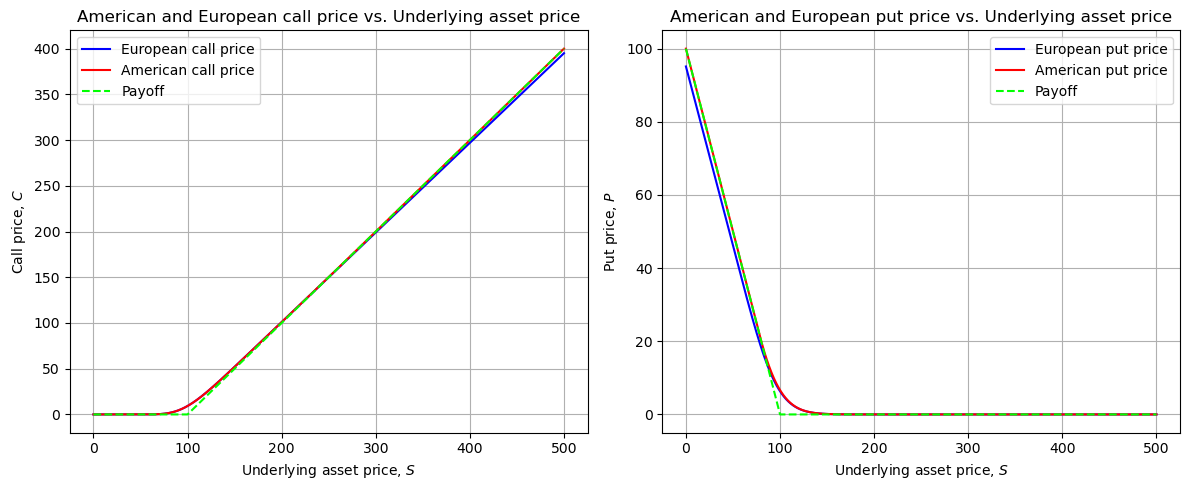

In [13]:
# Set up linear x-axis and compute American and European call and put prices as NumPy arrays for various underlying asset prices
american_call_t0, V_call, T_grid, S_grid = american_fd_price(St, T, K, r, q, sigma, S_max, N, M, theta, omega, tol, max_iter, option_type = "call")
american_put_t0, V_put, _, _ = american_fd_price(St, T, K, r, q, sigma, S_max, N, M, theta, omega, tol, max_iter, option_type = "put")

cn_calls = V_call[0, :]
cn_puts = V_put[0, :]

bs_calls = np.array([european_bs_price(St, T, K, r, q, sigma, option_type = "call") for St in S_grid])
bs_puts = np.array([european_bs_price(St, T, K, r, q, sigma, option_type = "put") for St in S_grid])

payoff_call = np.maximum(S_grid - K, 0.0)
payoff_put = np.maximum(K - S_grid, 0.0)

# Plot American and European prices as a function of underlying asset price. One graph for calls, one for puts
fig, (ax_calls, ax_puts) = plt.subplots(1, 2, figsize = (12, 5))

ax_calls.plot(S_grid, bs_calls, linestyle = "-", color = "blue", label = "European call price")
ax_calls.plot(S_grid, cn_calls, linestyle = "-", color = "red", label = "American call price")
ax_calls.plot(S_grid, payoff_call, linestyle = "--", color = "lime", label = "Payoff")
ax_calls.set_xlabel("Underlying asset price, $S$")
ax_calls.set_ylabel("Call price, $C$")
ax_calls.set_title("American and European call price vs. Underlying asset price")
ax_calls.grid()
ax_calls.legend()

ax_puts.plot(S_grid, bs_puts, linestyle = "-", color = "blue", label = "European put price")
ax_puts.plot(S_grid, cn_puts, linestyle = "-", color = "red", label = "American put price")
ax_puts.plot(S_grid, payoff_put, linestyle = "--", color = "lime", label = "Payoff")
ax_puts.set_xlabel("Underlying asset price, $S$")
ax_puts.set_ylabel("Put price, $P$")
ax_puts.set_title("American and European put price vs. Underlying asset price")
ax_puts.grid()
ax_puts.legend()

fig.tight_layout()
plt.show()

Saved: project/figures/appendixC/C4_american_free_boundary.pdf


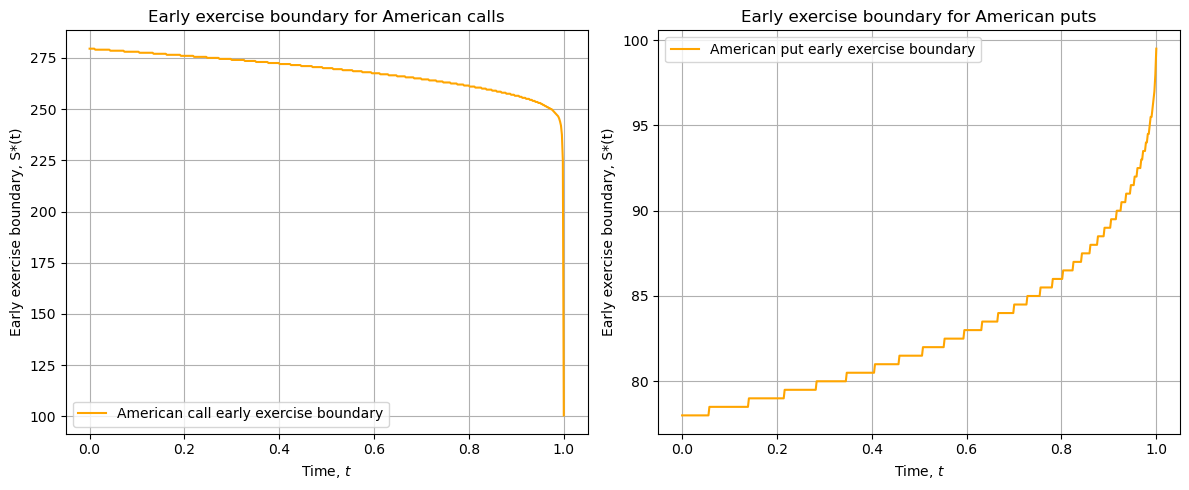

In [14]:
# Plot the free boundary for the American call and put options with q>0
american_call_t0, V_call, T_grid, S_grid = american_fd_price(St, T, K, r, q, sigma, S_max, N, M, theta, omega, tol, max_iter, option_type = "call")
american_put_t0, V_put, _, _ = american_fd_price(St, T, K, r, q, sigma, S_max, N, M, theta, omega, tol, max_iter, option_type = "put")

payoff_call_grid = np.maximum(S_grid - K, 0.0)
payoff_put_grid = np.maximum(K - S_grid, 0.0)
boundary_tol = 1e-3

N = T_grid.shape[0] - 1
S_star_call = np.full(N+1, np.nan)
S_star_put = np.full(N+1, np.nan)

# Build the free boundary curve
for n in range(N+1):

    diff_call = V_call[n, :] - payoff_call_grid
    ex_mask_call = (payoff_call_grid > 0.0) & (np.abs(diff_call) <= boundary_tol)
    
    if np.any(ex_mask_call):
        j_star_call = np.where(ex_mask_call)[0].min()
        S_star_call[n] = S_grid[j_star_call]

    diff_put = V_put[n, :] - payoff_put_grid
    ex_mask_put = (payoff_put_grid > 0.0) & (np.abs(diff_put) <= boundary_tol)
    
    if np.any(ex_mask_put):
        j_star_put = np.where(ex_mask_put)[0].max()
        S_star_put[n] = S_grid[j_star_put]


fig, (ax_calls, ax_puts) = plt.subplots(1, 2, figsize = (12, 5))

ax_calls.plot(T_grid, S_star_call, linestyle = "-", color = "orange", label = "American call early exercise boundary")
ax_calls.set_xlabel("Time, $t$")
ax_calls.set_ylabel("Early exercise boundary, S*(t)")
ax_calls.set_title("Early exercise boundary for American calls")
ax_calls.grid()
ax_calls.legend()

ax_puts.plot(T_grid, S_star_put, linestyle = "-", color = "orange", label = "American put early exercise boundary")
ax_puts.set_xlabel("Time, $t$")
ax_puts.set_ylabel("Early exercise boundary, S*(t)")
ax_puts.set_title("Early exercise boundary for American puts")
ax_puts.grid()
ax_puts.legend()

fig.tight_layout()
save_fig(fig, "C4_american_free_boundary", fmt="pdf")
plt.show()